# **Homework 7 - Bert (Question Answering)**

If you have any questions, feel free to email us at mlta-2022-spring@googlegroups.com



Slide:    [Link](https://docs.google.com/presentation/d/1H5ZONrb2LMOCixLY7D5_5-7LkIaXO6AGEaV2mRdTOMY/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw7)　Data: [Link](https://drive.google.com/uc?id=1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb)




## Task description
- Chinese Extractive Question Answering
  - Input: Paragraph + Question
  - Output: Answer

- Objective: Learn how to fine tune a pretrained model on downstream task using transformers

- Todo
    - Fine tune a pretrained chinese BERT model
    - Change hyperparameters (e.g. doc_stride)
    - Apply linear learning rate decay
    - Try other pretrained models
    - Improve preprocessing
    - Improve postprocessing
- Training tips
    - Automatic mixed precision
    - Gradient accumulation
    - Ensemble

- Estimated training time (tesla t4 with automatic mixed precision enabled)
    - Simple: 8mins
    - Medium: 8mins
    - Strong: 25mins
    - Boss: 2.5hrs
  

## Download Dataset

In [2]:
# Download link 1
#!gdown --id '1AVgZvy3VFeg0fX-6WQJMHPVrx3A-M1kb' --output hw7_data.zip

# Download Link 2 (if the above link fails)
#!gdown --id '1qwjbRjq481lHsnTrrF4OjKQnxzgoLEFR' --output hw7_data.zip

# Download Link 3 (if the above link fails)
# !gdown --id '1QXuWjNRZH6DscSd6QcRER0cnxmpZvijn' --output hw7_data.zip

#!unzip -o hw7_data.zip

# For this HW, K80 < P4 < T4 < P100 <= T4(fp16) < V100
!nvidia-smi

Sat Aug 10 19:27:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 552.41       CUDA Version: 12.4     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        On  | 00000000:01:00.0  On |                  N/A |
|  0%   35C    P8              11W / 320W |   2008MiB / 16376MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install transformers

Documentation for the toolkit:　https://huggingface.co/transformers/

In [3]:
# You are allowed to change version of transformers or use other toolkits
#!pip install transformers==4.5.0
!pip install transformers torch
!pip install matplotlib

## Import Packages

In [1]:
import json
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, BertForQuestionAnswering, BertTokenizerFast

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed for reproducibility
def same_seeds(seed):
	  torch.manual_seed(seed)
	  if torch.cuda.is_available():
		    torch.cuda.manual_seed(seed)
		    torch.cuda.manual_seed_all(seed)
	  np.random.seed(seed)
	  random.seed(seed)
	  torch.backends.cudnn.benchmark = False
	  torch.backends.cudnn.deterministic = True
same_seeds(0)

In [ ]:
#!pip install accelerate --force

In [4]:
# Change "fp16_training" to True to support automatic mixed precision training (fp16)
fp16_training = True

if fp16_training:
    from accelerate import Accelerator
    accelerator = Accelerator(mixed_precision="bf16", gradient_accumulation_steps=4)
    device = accelerator.device
else:
    device = device

# Documentation for the toolkit:  https://huggingface.co/docs/accelerate/

## Load Model and Tokenizer






In [6]:
model = BertForQuestionAnswering.from_pretrained("google-bert/bert-large-uncased").to(device)
tokenizer = BertTokenizerFast.from_pretrained("google-bert/bert-large-uncased")

# FacebookAI/xlm-roberta-base
# google-bert/bert-base-multilingual-cased
# google-bert/bert-base-chinese
# google-bert/bert-large-uncased
# FacebookAI/roberta-large

# You can safely ignore the warning message (it pops up because new prediction heads for QA are initialized randomly)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Read Data

- Training set: 31690 QA pairs
- Dev set: 4131  QA pairs
- Test set: 4957  QA pairs

- {train/dev/test}_questions:
  - List of dicts with the following keys:
   - id (int)
   - paragraph_id (int)
   - question_text (string)
   - answer_text (string)
   - answer_start (int)
   - answer_end (int)
- {train/dev/test}_paragraphs:
  - List of strings
  - paragraph_ids in questions correspond to indexs in paragraphs
  - A paragraph may be used by several questions

In [7]:
import os
import os.path

def dfs_showdir(path, depth):
    if depth == 0:
        print("root:[" + path + "]")

    for item in os.listdir(path):
        if '.git' not in item:
            print("|      " * depth + "+--" + item)

            newitem = path +'/'+ item
            if os.path.isdir(newitem):
                dfs_showdir(newitem, depth +1)

dfs_showdir('./', 0)

root:[./]
+--ml2022spring-hw7.zip
+--result_lr_update.csv
+--result_start_end_swap.csv
+--saved_model
|      +--model.safetensors
|      +--config.json
+--result_original.csv
+--result.csv
+--.ipynb_checkpoints
|      +--ml2022spring-hw7-colab-checkpoint.ipynb
|      +--result_start_end_swap-checkpoint.csv
|      +--hw7_train-checkpoint.json
|      +--result_original-checkpoint.csv
|      +--hw7_test-checkpoint.json
+--hw7_test.json
+--hw7_train.json
+--hw7_dev.json
+--ml2022spring-hw7-colab.ipynb


In [8]:
def read_data(file):
    with open(file, 'r', encoding="utf-8") as reader:
        data = json.load(reader)
    return data["questions"], data["paragraphs"]

# train_questions, train_paragraphs = read_data("hw7_train.json")
# dev_questions, dev_paragraphs = read_data("hw7_dev.json")
# test_questions, test_paragraphs = read_data("hw7_test.json")
train_questions, train_paragraphs = read_data("hw7_train.json")
dev_questions, dev_paragraphs = read_data("hw7_dev.json")
test_questions, test_paragraphs = read_data("hw7_test.json")

## Tokenize Data

In [9]:
# Tokenize questions and paragraphs separately
# 「add_special_tokens」 is set to False since special tokens will be added when tokenized questions and paragraphs are combined in datset __getitem__

train_questions_tokenized = tokenizer([train_question["question_text"] for train_question in train_questions], add_special_tokens=False)
dev_questions_tokenized = tokenizer([dev_question["question_text"] for dev_question in dev_questions], add_special_tokens=False)
test_questions_tokenized = tokenizer([test_question["question_text"] for test_question in test_questions], add_special_tokens=False)

train_paragraphs_tokenized = tokenizer(train_paragraphs, add_special_tokens=False)
dev_paragraphs_tokenized = tokenizer(dev_paragraphs, add_special_tokens=False)
test_paragraphs_tokenized = tokenizer(test_paragraphs, add_special_tokens=False)

# You can safely ignore the warning message as tokenized sequences will be futher processed in datset __getitem__ before passing to model

Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


In [10]:
print (test_questions_tokenized.data['input_ids'][0])
print (test_questions_tokenized.data['token_type_ids'][0])
print (test_questions_tokenized.data['attention_mask'][0])

[1807, 100, 1967, 1916, 100, 100, 1742, 100, 1873, 100, 100, 100, 100, 1029]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


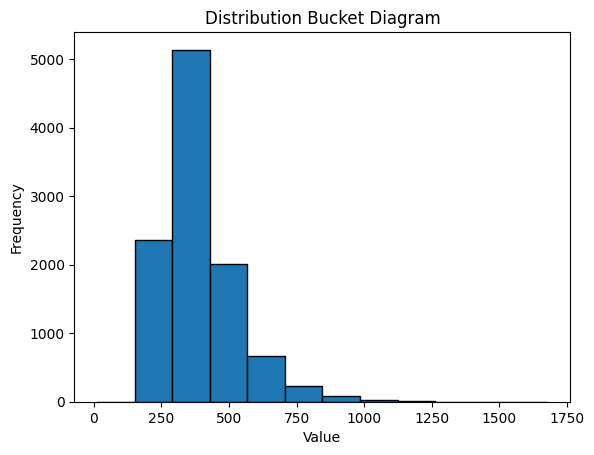

In [11]:
import matplotlib.pyplot as plt

data = [len(train_paragrpah) for train_paragrpah in train_paragraphs_tokenized.data['input_ids']]
num_bins = 12
# Create the histogram
plt.hist(data, bins=num_bins, edgecolor='black')

# Add titles and labels
plt.title('Distribution Bucket Diagram')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()
#print((train_paragraphs_tokenized.data['input_ids'][0]))
#print (data)

In [12]:
print (train_questions_tokenized.data['input_ids'][0])
print (train_questions_tokenized.data['token_type_ids'][0])
print (train_questions_tokenized.data['attention_mask'][0])

[100, 1980, 100, 1917, 100, 100, 1741, 1745, 100, 5385, 1840, 1888, 100, 1779, 100, 100, 100, 100, 1980, 1756, 1916, 1917, 1838, 1029]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
print(test_questions_tokenized.data.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


## Dataset and Dataloader

In [14]:
class QA_Dataset(Dataset):
    def __init__(self, split, questions, tokenized_questions, tokenized_paragraphs):
        self.split = split
        self.questions = questions
        self.tokenized_questions = tokenized_questions
        self.tokenized_paragraphs = tokenized_paragraphs
        self.max_question_len = 40
        self.max_paragraph_len = 150

        ##### TODO: Change value of doc_stride #####
        self.doc_stride = 75

        # Input sequence length = [CLS] + question + [SEP] + paragraph + [SEP]
        self.max_seq_len = 1 + self.max_question_len + 1 + self.max_paragraph_len + 1

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        tokenized_question = self.tokenized_questions[idx]
        tokenized_paragraph = self.tokenized_paragraphs[question["paragraph_id"]]

        ##### TODO: Preprocessing #####
        # Hint: How to prevent model from learning something it should not learn

        if self.split == "train":
            # Convert answer's start/end positions in paragraph_text to start/end positions in tokenized_paragraph
            answer_start_token = tokenized_paragraph.char_to_token(question["answer_start"])
            answer_end_token = tokenized_paragraph.char_to_token(question["answer_end"])

            # A single window is obtained by slicing the portion of paragraph containing the answer
            mid = (answer_start_token + answer_end_token) // 2
            paragraph_start = max(0, min(mid - self.max_paragraph_len // 2, len(tokenized_paragraph) - self.max_paragraph_len))
            paragraph_end = paragraph_start + self.max_paragraph_len

            # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
            input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
            input_ids_paragraph = tokenized_paragraph.ids[paragraph_start : paragraph_end] + [102]

            # Convert answer's start/end positions in tokenized_paragraph to start/end positions in the window
            answer_start_token += len(input_ids_question) - paragraph_start
            answer_end_token += len(input_ids_question) - paragraph_start

            # Pad sequence and obtain inputs to model
            input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)
            return torch.tensor(input_ids), torch.tensor(token_type_ids), torch.tensor(attention_mask), answer_start_token, answer_end_token

        # Validation/Testing
        else:
            input_ids_list, token_type_ids_list, attention_mask_list = [], [], []

            # Paragraph is split into several windows, each with start positions separated by step "doc_stride"
            for i in range(0, len(tokenized_paragraph), self.doc_stride):

                # Slice question/paragraph and add special tokens (101: CLS, 102: SEP)
                input_ids_question = [101] + tokenized_question.ids[:self.max_question_len] + [102]
                input_ids_paragraph = tokenized_paragraph.ids[i : i + self.max_paragraph_len] + [102]

                # Pad sequence and obtain inputs to model
                input_ids, token_type_ids, attention_mask = self.padding(input_ids_question, input_ids_paragraph)

                input_ids_list.append(input_ids)
                token_type_ids_list.append(token_type_ids)
                attention_mask_list.append(attention_mask)

            return torch.tensor(input_ids_list), torch.tensor(token_type_ids_list), torch.tensor(attention_mask_list)

    def padding(self, input_ids_question, input_ids_paragraph):
        # Pad zeros if sequence length is shorter than max_seq_len
        padding_len = self.max_seq_len - len(input_ids_question) - len(input_ids_paragraph)
        # Indices of input sequence tokens in the vocabulary
        input_ids = input_ids_question + input_ids_paragraph + [0] * padding_len
        # Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]
        token_type_ids = [0] * len(input_ids_question) + [1] * len(input_ids_paragraph) + [0] * padding_len
        # Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]
        attention_mask = [1] * (len(input_ids_question) + len(input_ids_paragraph)) + [0] * padding_len

        return input_ids, token_type_ids, attention_mask

train_set = QA_Dataset("train", train_questions, train_questions_tokenized, train_paragraphs_tokenized)
dev_set = QA_Dataset("dev", dev_questions, dev_questions_tokenized, dev_paragraphs_tokenized)
test_set = QA_Dataset("test", test_questions, test_questions_tokenized, test_paragraphs_tokenized)

train_batch_size = 128

# Note: Do NOT change batch size of dev_loader / test_loader !
# Although batch size=1, it is actually a batch consisting of several windows from the same QA pair
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=True)
dev_loader = DataLoader(dev_set, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

## Function for Evaluation

In [15]:
def evaluate(data, output):
    ##### TODO: Postprocessing #####
    # There is a bug and room for improvement in postprocessing
    # Hint: Open your prediction file to see what is wrong

    answer = ''
    max_prob = float('-inf')
    num_of_windows = data[0].shape[1]

    for k in range(num_of_windows):
        # Obtain answer by choosing the most probable start position / end position
        start_prob, start_index = torch.max(output.start_logits[k], dim=0)
        end_prob, end_index = torch.max(output.end_logits[k], dim=0)

        # Probability of answer is calculated as sum of start_prob and end_prob
        prob = start_prob + end_prob

        if (start_index > end_index):
            #pass
            (start_index, end_index) = (end_index, start_index) # swap start and end if start > end

        # Replace answer if calculated probability is larger than previous windows
        if prob > max_prob:
            max_prob = prob
            # Convert tokens to chars (e.g. [1920, 7032] --> "大 金")
            answer = tokenizer.decode(data[0][0][k][start_index : end_index + 1])

    # Remove spaces in answer (e.g. "大 金" --> "大金")
    return answer.replace(' ','')

## Training

In [ ]:
from transformers import get_linear_schedule_with_warmup

num_epoch = 1
validation = True
logging_step = 100
learning_rate = 1e-4
optimizer = AdamW(model.parameters(), lr=learning_rate)

train_data_size = train_set.__len__()
t_total = train_data_size // train_batch_size * num_epoch  # Total number of training steps
warmup_steps = 0.1 * t_total  # Warmup steps as a fraction of total training steps

# Define the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
)

if fp16_training:
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

model.train()

print("Start Training ...")
print(type(device))

for epoch in range(num_epoch):
    step = 1
    train_loss = train_acc = 0

    for data in tqdm(train_loader):
        # Load all data into GPU
        data = [i.to(device) for i in data]

        # Model inputs: input_ids, token_type_ids, attention_mask, start_positions, end_positions (Note: only "input_ids" is mandatory)
        # Model outputs: start_logits, end_logits, loss (return when start_positions/end_positions are provided)
        #with torch.autocast(device_type=device, dtype=torch.bfloat16):
        output = model(input_ids=data[0], token_type_ids=data[1], attention_mask=data[2], start_positions=data[3], end_positions=data[4])

        # Choose the most probable start position / end position
        start_index = torch.argmax(output.start_logits, dim=1)
        end_index = torch.argmax(output.end_logits, dim=1)

        # Prediction is correct only if both start_index and end_index are correct
        train_acc += ((start_index == data[3]) & (end_index == data[4])).float().mean()
        train_loss += output.loss

        if fp16_training:
            accelerator.backward(output.loss)
        else:
            output.loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        step += 1

        ##### TODO: Apply linear learning rate decay #####
        lr = optimizer.param_groups[0]['lr']
        lr -= lr / step / step
        if (lr < 0):
            lr = -lr
        #optimizer.param_groups[0]['lr'] = lr
        if (step % 10 == 0):
            pass
            #print(lr)

        

        # Print training loss and accuracy over past logging step
        if step % logging_step == 0:
            print(f"Epoch {epoch + 1} | Step {step} | loss = {train_loss.item() / logging_step:.3f}, acc = {train_acc / logging_step:.3f}")
            train_loss = train_acc = 0

    if validation:
        print("Evaluating Dev Set ...")
        model.eval()
        with torch.no_grad():
            dev_acc = 0
            for i, data in enumerate(tqdm(dev_loader)):
                #with torch.autocast(device_type=device, dtype=torch.bfloat16):
                output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
                # prediction is correct only if answer text exactly matches
                dev_acc += evaluate(data, output) == dev_questions[i]["answer_text"]
            print(f"Validation | Epoch {epoch + 1} | acc = {dev_acc / len(dev_loader):.3f}")
        model.train()

# Save a model and its configuration file to the directory 「saved_model」
# i.e. there are two files under the direcory 「saved_model」: 「pytorch_model.bin」 and 「config.json」
# Saved model can be re-loaded using 「model = BertForQuestionAnswering.from_pretrained("saved_model")」
print("Saving Model ...")
model_save_dir = "saved_model"
model.save_pretrained(model_save_dir)

/home/liuji/miniconda3/envs/bert/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start Training ...
<class 'torch.device'>


  0%|          | 0/248 [00:00<?, ?it/s]

## Testing

In [41]:
print("Evaluating Test Set ...")

result = []

model.eval()
with torch.no_grad():
    for data in tqdm(test_loader):
        output = model(input_ids=data[0].squeeze(dim=0).to(device), token_type_ids=data[1].squeeze(dim=0).to(device),
                       attention_mask=data[2].squeeze(dim=0).to(device))
        result.append(evaluate(data, output))

result_file = "result.csv"
with open(result_file, 'w') as f:
	  f.write("ID,Answer\n")
	  for i, test_question in enumerate(test_questions):
        # Replace commas in answers with empty strings (since csv is separated by comma)
        # Answers in kaggle are processed in the same way
		    f.write(f"{test_question['id']},{result[i].replace(',','')}\n")

print(f"Completed! Result is in {result_file}")

Evaluating Test Set ...


  0%|          | 0/4957 [00:00<?, ?it/s]

Completed! Result is in result.csv
